<a href="https://colab.research.google.com/github/merkhaiburch/hackathons/blob/main/2021_09_ml/src/baseline_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training a baseline CNN on ATATCseq peaks cis to genes to predict v4 expression in B73. Using raw expression from the max across-tissue Giri cis-HARE expression and potentially the Kremling 7-tissue dataset.

We will use DanQ and/or DeepSEA


Tasks to Do
* Create padded sequences
* Create an un-padded sequences
* Connect sequences to expression data
* One hot encode DNA sequences
* Create training and test sets
* Create two models
        DeepSea if time
        DanQ
* Fit model object with training data set
* Calculate ROC between models

Import libraries

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
import numpy as np

In [26]:
# Mount drive to find data
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import seqeunce information and expression data

In [27]:
# path where data lives on drive
data_path = '/content/drive/MyDrive/HackTravis_Sept2021'

# Import expression data
genes = pd.read_csv((data_path +"/Expression_Datasets/exp_b73_max_cis_trans_model.csv"))

# import atac-seq peak seqeunce
atac_10k = pd.read_csv((data_path + "/Regulatory_DNA/single_peak_cutoff_250.tsv"), sep = '\t')

# combine atac and expression data
exp_atac = genes.merge(atac_10k, left_on='v4_gene', right_on='gene')

              v4_gene  max_cis_rna_value
0      Zm00001d007725           0.000000
1      Zm00001d007718           0.000000
2      Zm00001d007717           0.000000
3      Zm00001d007716           0.000000
4      Zm00001d018986           0.000000
...               ...                ...
34351  Zm00001d010516           9.052502
34352  Zm00001d032787           0.155082
34353  Zm00001d034682           0.000000
34354  Zm00001d043862           0.000000
34355  Zm00001d015476          16.060915

[34356 rows x 2 columns]
                gene                                                DNA
0     Zm00001d001771  CTCGTGATAAAATTAAAATGAACTGAGCCGAGTCGTGGCAAACTGA...
1     Zm00001d001774  CAATTTTTCTCCCCGCACCGCACGCCACGCCACGCCATAATTAAAC...
2     Zm00001d001776  TTGTCCTAGGGCGCGAGGGGTCGAGAGGGCCCATTGTATTGGGTGC...
3     Zm00001d001780  TCCCGATTACAGGCATGTCGGTACAAATAAACCAGGAAATATTCCC...
4     Zm00001d001785  GTCATCAAACCCACGCTTCCAATTCTACTACGGAGGAGAGGTAACG...
...              ...                              

16127

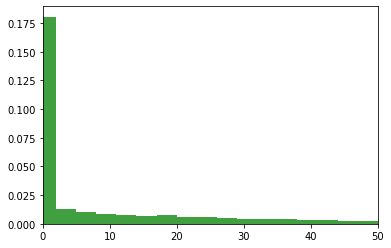

In [28]:
# Plot expression histogram
n, bins, patches = plt.hist(genes["max_cis_rna_value"], 10000, density=True, facecolor='g', alpha=0.75)
plt.xlim(0,50)
genes.describe()
(genes["max_cis_rna_value"] == 0).sum()

In [29]:
# If genes > 0 --> expressed/TRUE, if <= 0 --> notExpressed/FALSE
exp_atac["expressed"] = np.where(exp_atac["max_cis_rna_value"] > 0, 0, 1)

# Drop extra columns
exp_atac = exp_atac[["v4_gene", "DNA", "expressed"]]

# rename columns
exp_atac.columns = ["gene", "seq", "target"]

### Test to see if the model is learning anything by adding random seqeunce onto all expressed genes

Look at dataset:
- are there an equal number of expressed and non expressed genes? --> more unexpressed than expressed
- What is the correlation in gene expression and the # of atacseq peaks? --> dont have the right data yet

In [30]:
# Count number of expressed and non-expressed genes
print("Number of un-expressed genes:", (exp_atac["target"] == 0).sum())
print("Number of expressed genes:", (exp_atac["target"] == 1).sum())

Number of un-expressed genes: 3406
Number of expressed genes: 1969


Split training, validation, test data based on the Washburn 2019 gene families using a 80, 10, 10 split.

In [31]:
# load in data
washburn = pd.read_csv((data_path +"/washburn_training_test_v4_unexpressed_v_expressed.csv"))

# drop extra column
washburn = washburn[["v4", "family_index"]]

# create train and test indicies
from sklearn.model_selection import GroupShuffleSplit
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(washburn, groups=washburn['family_index']))

# Split data 80:20
train = washburn.iloc[train_inds]
test = washburn.iloc[test_inds]

# Split test into a test and validation (0:10)
test2_inds, validation_inds = next(GroupShuffleSplit(test_size=.5, n_splits=2, random_state = 7).split(test, groups=test['family_index']))

test2 = test.iloc[test2_inds]
validation = test.iloc[validation_inds]

# Print out dimensions of training and test data
print(train.shape, test2.shape, validation.shape)
print(validation)

(27984, 2) (3652, 2) (2720, 2)
                   v4  family_index
0      Zm00001d007725           152
22     Zm00001d048307          2973
25     Zm00001d048310           374
45     Zm00001d042723           204
47     Zm00001d039411            84
...               ...           ...
34338  Zm00001d001825            84
34340  Zm00001d035014          9081
34341  Zm00001d030638          1114
34342  Zm00001d009811           653
34345  Zm00001d011122          9083

[2720 rows x 2 columns]


Merge training, test, and validation with sequence information

In [32]:
train = train.merge(exp_atac, left_on= 'v4', right_on= 'gene')
test = test2.merge(exp_atac, left_on= 'v4', right_on= 'gene')
validation = validation.merge(exp_atac, left_on= 'v4', right_on= 'gene')

# Remove extra columns across files
train = train[['seq', 'target']]
test = test[['seq', 'target']]
validation = validation[['seq', 'target']]

print(train.shape, test.shape, validation.shape)
print(train)

(4958, 2) (627, 2) (488, 2)
                                                    seq  target
0     CACGTGCCGACGACCACGCCTCCGTGCCGGGTAAACCGCCTACAAA...       1
1     ACAAAAGGGTGGACGCGGAAGCCACGCACCTCGCCACCAGAAATTT...       1
2     TTAGATACCCGAAATATAAAAAATCCAAAAACCCGACCCGAAATAT...       1
3     AAAGGCACAAAGAAGCTTGTGGCGTCTGCATCTGCATGCGTTGTTG...       1
4     CGTCCGGGTCTCGGGTGCGGTGTCGAAGGGTCCTTGTCGAACGCCA...       1
...                                                 ...     ...
4953  TCGTCAACGACGAAGACTAGAATGCACTAGATGGATCCATTAGTAG...       0
4954  GGGCCGTTTCGAAGCCTATATAAGAAAAATAAAGAAAAAGGCCGTT...       0
4955  TCACCTGCTTCCTGTACCGCGTCGTTGCTTCTGTAGCTGCCCACAA...       0
4956  GAACAAAATATTTTAAAAAACGAATTTAAAAAAATAAGAAAATTAA...       1
4957  TGTTGCTACTTCTACAGGACCACCTTCGAAGGCAGTTTACGCTTTC...       0

[4958 rows x 2 columns]


DanQ model setup

In [33]:
# Create intervals, one hot encode them, return. Inputs: pandas dataframe with sequence and target data (expression)
# Taken from: https://bitbucket.org/bucklerlab/a2z-regulatory/src/master/src/python/a2z/a2z/data/__init__.py
import logging
from math import ceil
from typing import Optional, Dict

!pip install Bio
from Bio import Seq
import numpy as np
import pandas as pd
from tensorflow import keras as k


BASE_1HOT = {
    "A": np.array([1, 0, 0, 0]),
    "C": np.array([0, 1, 0, 0]),
    "G": np.array([0, 0, 1, 0]),
    "T": np.array([0, 0, 0, 1]),
    "W": np.array([0.5, 0, 0, 0.5]),
    "S": np.array([0, 0.5, 0.5, 0]),
    "M": np.array([0.5, 0.5, 0, 0]),
    "K": np.array([0, 0, 0.5, 0.5]),
    "R": np.array([0.5, 0, 0.5, 0]),
    "Y": np.array([0, 0.5, 0, 0.5]),
    "B": np.array([0, 1.0 / 3, 1.0 / 3, 1.0 / 3]),
    "D": np.array([1.0 / 3, 0, 1.0 / 3, 1.0 / 3]),
    "H": np.array([1.0 / 3, 1.0 / 3, 0, 1.0 / 3]),
    "V": np.array([1.0 / 3, 1.0 / 3, 1.0 / 3, 0]),
    "N": np.array([0.25, 0.25, 0.25, 0.25]),
}


def seq_one_hot_encode(seq: str, pad_to: Optional[int] = None):
    """ one-hot encodes a DNA sequence """
    if pad_to:
        encoded = np.zeros(shape=(pad_to, 4))
        if len(seq) > pad_to:
            seq = seq[:pad_to]
    else:
        encoded = np.zeros(shape=(len(seq), 4))

    for i, base in enumerate(seq.upper()):
        try:
            encoded[i, :] = BASE_1HOT[base]
        except KeyError:
            logging.error(
                f"Unrecognized base encountered during one-hot " f"encoding: '{base}'"
            )
    return encoded

class IntervalDataset(k.utils.Sequence):
    def __init__(self, intervals_df: pd.DataFrame, batch_size = 128, pad_to = None, no_target = False):
        self._df = intervals_df
        self.batch_size = batch_size
        self.pad_to = pad_to
        self.no_target = no_target

    def __len__(self):
        return ceil(len(self._df) / self.batch_size)

    def __getitem__(self, idx: int):
        batch_start_idx = idx * self.batch_size
        batch_intervals = self._df.iloc[batch_start_idx : batch_start_idx + self.batch_size]
        try:
            x = np.stack([seq_one_hot_encode(seq, self.pad_to) for seq in batch_intervals['seq']])
        except ValueError as e:
            logging.error("ValueError encountered while trying to one-hot encode sequence batches, are all of your sequences the same length?")
            raise e
        if self.no_target:
            y = None
        else:
            y = np.expand_dims(batch_intervals['target'].to_numpy(), axis = 1)

        return (x, y)


In [34]:
# create interval refernces (sequence and target --> character DNA and target DNA seqeunce)
# taken from: https://bitbucket.org/bucklerlab/a2z-regulatory/src/master/results/2020-11-13_fig1/train.py
training_data = IntervalDataset(train)
validation_data = IntervalDataset(validation)
test_data = IntervalDataset(test)

Build DanQ model

In [60]:
import imp
import tensorflow.keras.layers as kl

def build_DanQ(window_size: int = 300, conv_activation = 'relu') -> keras.Model:
    DanQ = keras.Sequential([
        kl.Conv1D(320, 26, activation = conv_activation, input_shape = (window_size, 4)),
        kl.Dropout(0.2),
        kl.MaxPool1D(13, 13),
        kl.Bidirectional(kl.LSTM(320)),
        kl.Dropout(0.5),
        kl.Dense(925),
        kl.Dense(1, activation = 'sigmoid')
        ], name = "DanQ")
    return DanQ

# Build DanQ model
model = build_DanQ(250)

# Change learning rate
from keras import metrics
optimizer = keras.optimizers.Adam(learning_rate=10)
model.compile(loss='BCE',
              optimizer=optimizer, 
              metrics=['accuracy'])

Fit DanQ model to out data

In [61]:
# Set parameters
validation_freq = 1
epochs = 13

# Fit model
train_history = model.fit(
    training_data,
    validation_data = validation_data,
    validation_freq = validation_freq,
    epochs = epochs,
    workers = 1,
    verbose = 0)

Look at model prediction accuracy

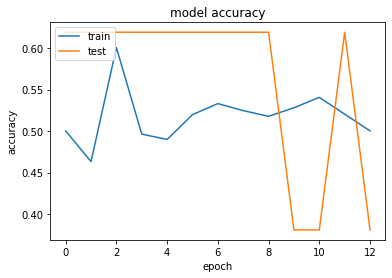

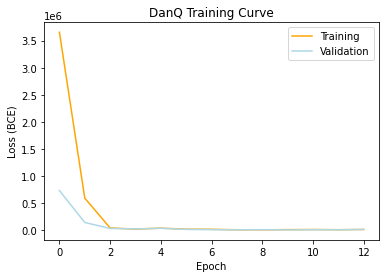

In [62]:
# summarize history for accuracy
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plot training curves --> loss vs epoch
fig, ax = plt.subplots()
ax.plot(train_history.epoch, train_history.history['loss'], color = 'orange', label = 'Training')
ax.plot(np.arange(validation_freq - 1, epochs, validation_freq), train_history.history['val_loss'], color = 'lightblue', label = 'Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel(f"Loss ({model.loss})")
ax.set_title(f"{model.name} Training Curve")
ax.legend()

Look at model predictions with test set

Generate predictions


Text(0.5, 1.0, 'Predicted vs Observed max-HARE Expression')

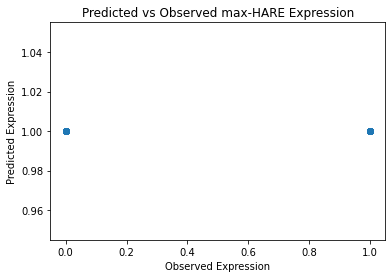

In [67]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions")
predictions = model.predict(test_data)

# plot predictions vs actual data
import matplotlib.pyplot as plt
plt.scatter(test['target'], predictions)
plt.xlabel('Observed Expression')
plt.ylabel("Predicted Expression")
plt.title("Predicted vs Observed max-HARE Expression")

Calculate a single value to describe the AuROC

In [ ]:
 auROC = roc_auc_score(y, y_hat)

Create ROC, PR, and TPR curves.

Taken from: https://bitbucket.org/bucklerlab/a2z-regulatory/src/master/src/python/a2z/a2z/plots.py

In [69]:
from collections import Counter
from typing import Iterable

import numpy as np
from matplotlib.figure import Figure
from matplotlib.patches import FancyBboxPatch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import roc_curve as sk_roc_curve

def pr_curve(y_true: Iterable, scores: Iterable) -> Figure:
    fig, ax = plt.subplots()

    # determine baseline
    true_cnt = Counter(y_true)
    n = sum(true_cnt.values())
    n_true = true_cnt[1]
    base_y = n_true / n

    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    ax.plot(recall, precision)
    ax.plot([0, 1], [base_y] * 2, color="gray", linestyle="--", label="Baseline")
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("PR Curve")
    ax.legend()

    return fig


def tpr_curve(y_true: Iterable, scores: Iterable) -> Figure:
    """ F1 baseline credit: https://stats.stackexchange.com/questions/390200/what-is-the-baseline-of-the-f1-score-for-a-binary-classifier  """
    fig, ax = plt.subplots()

    # determine baseline
    true_cnt = Counter(y_true)
    n = sum(true_cnt.values())
    n_true = true_cnt[1]
    base_y = n_true / n

    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    f1 = 2 * ((precision * recall) / (precision + recall))
    f1_baseline = (2 * base_y) / (base_y + 1)
    ax.plot(thresholds, precision[:-1], label = "Precision")
    ax.plot(thresholds, recall[:-1], label = "Recall")
    ax.plot(thresholds, f1[:-1], label = "F1 Score")
    ax.plot([0, 1], [base_y] * 2, color="gray", linestyle="--", label="Precision Baseline")
    ax.plot([0, 1], [f1_baseline] * 2, color="lightgray", linestyle = "--", label="F1 Baseline")
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Metric")
    ax.set_title("TPR Curve")
    ax.legend()

    return fig


def roc_curve(y_true: Iterable, scores: Iterable) -> Figure:
    fig, ax = plt.subplots()

    fpr, tpr, thresholds = sk_roc_curve(y_true, scores)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Baseline")
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend()

    return fig

In [71]:
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, average_precision_score, f1_score
auROC = roc_auc_score(test['target'], predictions)
print(auROC)

0.5


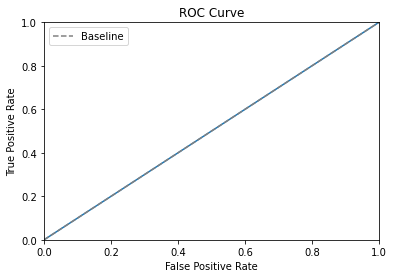

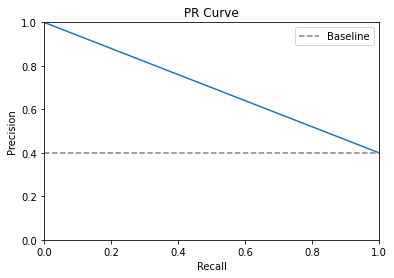

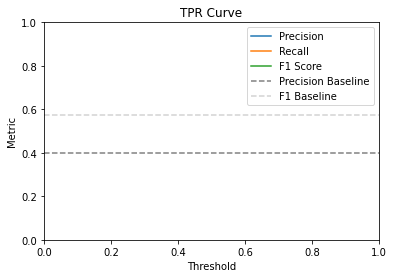

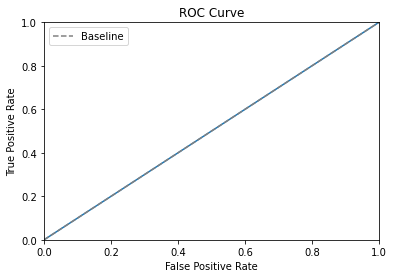

In [70]:
# Actually make plots

pr_curve(test['target'], predictions)
tpr_curve(test['target'], predictions)
roc_curve(test['target'], predictions)